In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os, sys
repo = '/content/drive/MyDrive/university/Optimization/frank-wolf-optimization'
os.chdir(repo)
sys.path.append(os.path.join(repo, 'src'))

In [7]:
!ls

data  README.md  requirements.txt  src



=== Dataset: ml-100k ===


Pairwise-FW: 100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


 FW      → Train RMSE: 0.9305, Test RMSE: 0.9294, Iters: 100, Time: 13.5s
 Pairwise→ Train RMSE: 0.9305, Test RMSE: 0.9294, Iters: 100, Time: 13.5s


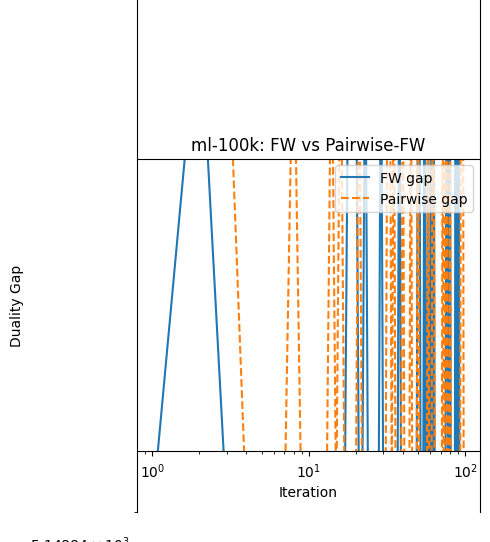


=== All results ===
Dataset  |   FW (train,test,iter,time)   |   Pairwise (train,test,iter,time)
ml-100k  --- (np.float64(0.9305089225927788), np.float64(0.9294266625374663), 100, 13.50150990486145) ---  (np.float64(0.9305089225927788), np.float64(0.9294266625374663), 100, 13.49175763130188)


In [11]:
import numpy as np
from scipy.sparse.linalg import svds
from tqdm import trange
import time
import matplotlib.pyplot as plt
from utils import load_dataset, evaluate
from solvers import FrankWolfe, PairwiseFrankWolfe
    ####
class MatrixCompletionObjective:
    def __init__(self, M_obs: np.ndarray, mask: np.ndarray):
        """
        Half squared error on observed entries.

        M_obs : observed entries (zeros elsewhere)
        mask  : boolean mask of observed entries
        """
        self.M_obs = M_obs
        self.mask = mask

    def value(self, X: np.ndarray) -> float:
        diff = (X - self.M_obs) * self.mask
        return 0.5 * np.sum(diff ** 2)

    def gradient(self, X: np.ndarray) -> np.ndarray:
        grad = np.zeros_like(X)
        grad[self.mask] = (X - self.M_obs)[self.mask]
        return grad

def nuclear_norm_lmo(grad: np.ndarray, tau: float) -> np.ndarray:
    """
    LMO over nuclear-norm ball: -tau * u1 v1^T
    Falls back to full numpy SVD if svds fails to converge.
    """
    try:
        # try fast truncated SVD
        u, s, vt = svds(-grad, k=1, tol=1e-2, maxiter=200)
        if s[0] <= 0:
            raise RuntimeError("svds returned non‐positive singular value")
    except Exception:
        # fallback to full SVD
        U, S, VT = np.linalg.svd(-grad, full_matrices=False)
        u = U[:, :1]
        vt = VT[:1, :]

    # combine top singular vectors into the rank-1 atom
    return -tau * (u @ vt)

def main():
    DATASETS = [
        ("ml-100k", "./data/ml-100k/u.data"),
        # ("jester2", "./data/jester2/jester_ratings.dat"),
        # ("ml-1m",   "../data/ml-1m/ratings.dat"),
    ]

    common_cfg = dict(
        lmo_fn      = nuclear_norm_lmo,
        tau         = 10.0,
        max_iter    = 100,
        tol         = 1e-4,
        step_method = 'analytic'   # or 'analytic'
    )

    results = []
    for name, path in DATASETS:
        print(f"\n=== Dataset: {name} ===")
        M_obs, mask_train, M_true = load_dataset(
            name=name,
            path=path,
            test_fraction=0.2,
            seed=42
        )
        obj = MatrixCompletionObjective(M_obs, mask_train)

        # Standard FW
        fw = FrankWolfe(objective=obj, **common_cfg)
        t0 = time.time()
        X_fw = fw.run()
        t_fw = time.time() - t0
        iters_fw, gaps_fw, vals_fw = zip(*fw.history)
        rmse_fw_train = np.sqrt(2 * obj.value(X_fw) / mask_train.sum())
        rmse_fw_test  = evaluate(M_true, X_fw, ~mask_train)

        # Pairwise‐FW
        pw = PairwiseFrankWolfe(objective=obj, **common_cfg)
        t0 = time.time()
        X_pw = pw.run()
        t_pw = time.time() - t0
        iters_pw, gaps_pw, vals_pw = zip(*pw.history)
        rmse_pw_train = np.sqrt(2 * obj.value(X_pw) / mask_train.sum())
        rmse_pw_test  = evaluate(M_true, X_pw, ~mask_train)

        # Print summary for this dataset
        print(f" FW      → Train RMSE: {rmse_fw_train:.4f}, Test RMSE: {rmse_fw_test:.4f}, "
              f"Iters: {len(iters_fw)}, Time: {t_fw:.1f}s")
        print(f" Pairwise→ Train RMSE: {rmse_pw_train:.4f}, Test RMSE: {rmse_pw_test:.4f}, "
              f"Iters: {len(iters_pw)}, Time: {t_pw:.1f}s")

        # Plot duality gaps
        plt.figure(figsize=(5,4))
        plt.loglog(iters_fw, gaps_fw, 'C0-', label='FW gap')
        plt.loglog(iters_pw, gaps_pw, 'C1--', label='Pairwise gap')
        plt.xlabel('Iteration')
        plt.ylabel('Duality Gap')
        plt.title(f'{name}: FW vs Pairwise-FW')
        plt.legend()
        plt.tight_layout()
        plt.show()

        results.append((name,
                        (rmse_fw_train, rmse_fw_test, len(iters_fw), t_fw),
                        (rmse_pw_train, rmse_pw_test, len(iters_pw), t_pw)))

    # Final table
    print("\n=== All results ===")
    print("Dataset  |   FW (train,test,iter,time)   |   Pairwise (train,test,iter,time)")
    for name, rfw, rpw in results:
        print(f"{name:8s} --- {rfw} ---  {rpw}")



if __name__ == "__main__":
    main()
